In [13]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

# RoPE

- [paper](https://arxiv.org/pdf/2104.09864v5.pdf)
- based on [MLX](https://github.com/ml-explore/mlx/blob/b0cd092b7f647044c4ed40bb40fa9d14bacc48f6/python/mlx/nn/layers/positional_encoding.py#L10)

In [27]:
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dims = dim
        
    def create_cos_sin_theta(self, N, D, offset, base=10_000, dtype=torch.float32):
        D = D // 2
        positions = torch.arange(offset, N, dtype=dtype)
        freqs = torch.exp(-torch.arange(0.0, D, dtype=dtype) * (math.log(base) / D))
        theta = torch.reshape(positions, (-1, 1)) * torch.reshape(freqs, (1, -1))
        costheta = torch.cos(theta)
        sintheta = torch.sin(theta)

        return costheta, sintheta
    
    def _compute_rope(self, costheta, sintheta, x):
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        rx1 = x1 * costheta - x2 * sintheta
        rx2 = x1 * sintheta + x2 * costheta

        rx = torch.cat([rx1[..., None], rx2[..., None]], dim=-1)

        return rx
    
    def forward(self, x, offset=0):
        shape = x.shape
        x = torch.reshape(x, (-1, shape[-2], shape[-1]))
        N = x.shape[1] + offset
        
        costheta, sintheta = self.create_cos_sin_theta(
            N, self.dims, offset=offset, dtype=x.dtype
        )

        rx = self._compute_rope(costheta, sintheta, x)
        
        return torch.reshape(rx, shape)

In [41]:
# the dim should be the head_dim
rope_posembeds = RoPE(4096 // 16)

In [46]:
out = rope_posembeds(torch.rand(1,128,4096//16))
out.shape

torch.Size([1, 128, 256])

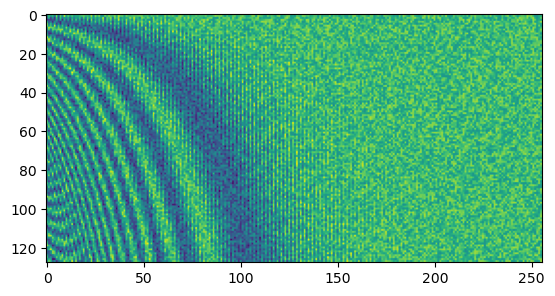

In [47]:
plt.imshow(out.squeeze())